# Problem 13: Traveling Salesperson Problem

This problem will test your ability to translate a non-trivial algorithm into code. More specifically, you will "solve" the [Traveling Salesperson Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) in this notebook. 
> The traveling salesperson problem (TSP) statement is: given `N` cities and the distances between each pair of cities, calculate the shortest _tour_, which is a path that visits each city once and then returns to the origin city.

This problem is in a class of problems called [NP-complete](https://en.wikipedia.org/wiki/NP-completeness). Roughly speaking, that means there is no known way to calculate the exact solution in a time that is less than exponential in the size of the input. For TSP, that's saying we need to check all possibilities, which is bad news, computationally speaking: a brute-force search to check all combinations of paths would need to run through `N!` possibilities, which for 20 cities, comes out to about $20! \approx 2 \cdot 10^{18}$ paths!

Thankfully, many heuristic or approximate solutions exist. You will implement one of these in this notebook.

## Simulated Annealing

[Simulated Annealing (SA)](https://en.wikipedia.org/wiki/Simulated_annealing) is a probablistic technique that can find good solutions to TSP, although it is not guaranteed to find the optimal solution. The rest of this notebook will walk you through how SA for TSP works.

Intuitively, SA tries to do the following. Suppose you are trying to minimize some cost function that has _many_ local minima. If you use traditional gradient-based methods, where you progressively take steps that always decrease the cost function, it's easy to fall into one of these and then "get stuck." The SA procedure says that as you are exploring potential solutions, you should occasionally take one even if it _increases_ the cost function. However, you should do so more frequently in the beginning, and gradually accept a higher cost solution less and less frequently as you go.

More formally, here is the high-level algorithmic idea:
1. Start with a random path through the cities
2. For some number of steps, iterate as follows:
    * Randomly swap two cities in the path
    * If this new path is shorter, accept it. Otherwise, accept it with probability ***p***
    * Repeat

The trick is to choose a value of ***p*** that shrinks as you near the end of the iteration. This means that early in the algorithm, you randomly choose worse-performing paths in the hopes that you will leave any local minima.

To see SA in action, see this animation of SA applied to a bunch of cities in the United States. (This illustration is taken from [toddwschneider.com](toddwschneider.com).)

![Simulated Annealing](http://toddwschneider.com/data/salesman/us_state_capitals_tsp.gif)

In the animation above, the "annealing schedule" is related to the probability of accepting a worse-solution, and the "current tour distance" shows you how the cost function decreases over time.

To get started, run the below code cell to import the necessary libraries and set up examples we will use.

#### If your values for `CITIES` and/or `RANDOM_PATH` variables change, you may need to re-run this code cell.

Matplotlib is building the font cache; this may take a moment.


20 generated cities:
[(17, 72), (97, 8), (32, 15), (63, 97), (57, 60), (83, 48), (26, 12), (62, 3), (49, 55), (77, 97), (98, 0), (89, 57), (34, 92), (29, 75), (13, 40), (3, 2), (3, 83), (69, 1), (48, 87), (27, 54)]


Randomly-generated path:
[0, 16, 7, 14, 15, 8, 3, 5, 13, 10, 11, 17, 4, 19, 9, 18, 6, 12, 1, 2]


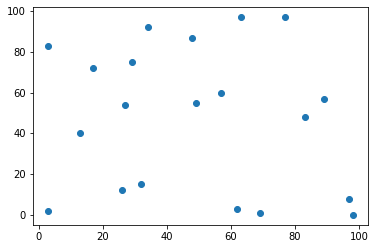

In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Set random seed for reproducibility
random.seed(1)

# Cities are (x, y) pairs in range [0, 100)
CITIES = [tuple(random.sample(range(100), 2)) for city in range(20)]
RANDOM_PATH = random.sample(range(20), 20)

print('20 generated cities:')
print(CITIES)
print('\n')
print('Randomly-generated path:')
print(RANDOM_PATH)

plt.scatter([c[0] for c in CITIES], [c[1] for c in CITIES])

The preceding code cell randomly generated 20 **"cities"**. Each city is represented by an ID from 0 to 19 inclusive and has **coordinates *(x, y)***, where both the *x* and *y* values lie in the *range [0,100)*. If `s` is a city ID, then `CITIES[s]` are its coordinates, stored as a tuple:

In [2]:
for s in range(len(CITIES)):
    print("City ID {} has coordinates {}.".format(s, CITIES[s]))

City ID 0 has coordinates (17, 72).
City ID 1 has coordinates (97, 8).
City ID 2 has coordinates (32, 15).
City ID 3 has coordinates (63, 97).
City ID 4 has coordinates (57, 60).
City ID 5 has coordinates (83, 48).
City ID 6 has coordinates (26, 12).
City ID 7 has coordinates (62, 3).
City ID 8 has coordinates (49, 55).
City ID 9 has coordinates (77, 97).
City ID 10 has coordinates (98, 0).
City ID 11 has coordinates (89, 57).
City ID 12 has coordinates (34, 92).
City ID 13 has coordinates (29, 75).
City ID 14 has coordinates (13, 40).
City ID 15 has coordinates (3, 2).
City ID 16 has coordinates (3, 83).
City ID 17 has coordinates (69, 1).
City ID 18 has coordinates (48, 87).
City ID 19 has coordinates (27, 54).


The preceding code cell also constructed a random **path** through the 20 cities. We define a **path** to be an ordering of the 20 cities. It is given as a list of the city IDs.

That is, if `path[:]` is a path, then `path[0]` is the ID of the first city on the path. That city's (x, y)-coordinates are given by `(CITIES[path[0]][0], CITIES[path[0]][1])`. The initial random path is stored in the list, `RANDOM_PATH[:]`. For instance:

In [3]:
print("Here is the initial random path {}".format(RANDOM_PATH))
print("The **second** city on the path has ID {}.".format(RANDOM_PATH[1]))
print("Its coordinates are {}.".format(CITIES[RANDOM_PATH[1]]))

Here is the initial random path [0, 16, 7, 14, 15, 8, 3, 5, 13, 10, 11, 17, 4, 19, 9, 18, 6, 12, 1, 2]
The **second** city on the path has ID 16.
Its coordinates are (3, 83).


Here is a picture of the initial random path:

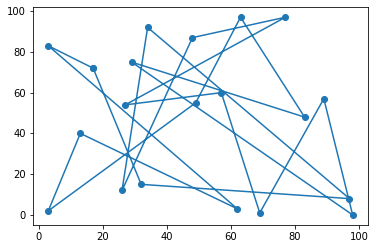

In [4]:
def plot_path(path, cities):
    n=len(cities)
    plt.plot([cities[path[k % n]][0] for k in range(n+1)], [cities[path[k % n]][1] for k in range(n+1)], marker='o')
    
plot_path(RANDOM_PATH, CITIES)

Lastly, you will need the following function, which calculates the Euclidean distance between two cities.

In [5]:
def euclidean_distance(city_a, city_b):
    return math.sqrt((city_b[0] - city_a[0])**2 + (city_b[1] - city_a[1])**2)

# Demo:
first_city = RANDOM_PATH[0]
second_city = RANDOM_PATH[1]
print("The distance between the first two cities on the path, {} and {}, is {}.".format(first_city,
                                                                                        second_city,
                                                                                        euclidean_distance(CITIES[first_city],
                                                                                                           CITIES[second_city])))

The distance between the first two cities on the path, 0 and 16, is 17.804493814764857.


**Exercise 0** (3 points): Let's get started on a helper function for your final algorithm implementation. One of the most important functions for this algorithm is the one used to calculate the total distance for a given path through all cities.

Write a function:
```python
def calculate_path_distance(path, cities)```

that takes two inputs,

1. `path`, a list in the same format as `RANDOM_PATH` above; and
2. `cities`, a list of tuples in the same format as `CITIES` above;

and returns the total distance of a round-trip tour through the cities. That is, `path` represents an **ordering** of the `cities`, representing a path that visits each city in `cities`, and your function should calculate the length of this path **including the return to the origin city**.

Take a path of 20 cities as an example (pay special attention to the last term):

$$
\newcommand{\pathdist}{\mathrm{path\ distance}}
\newcommand{\dist}{\mathrm{dist}}
\newcommand{\cities}{\mathrm{cities}}
\newcommand{\path}{\mathrm{path}}
\begin{equation}
\pathdist = \dist(\cities[\path[0]], \cities[\path[1]]) + \dist(\cities[\path[1]], \cities[\path[2]]) + \ldots + \dist(\cities[\path[19]], \cities[\path[0]]),
\end{equation}
$$

where $\dist(A, B)$, for two cities $A$ and $B$, is the Euclidean distance, **defined in the code cell above** as

$$\dist(A, B) = \sqrt{(B[0] - A[0])^2 + (B[1] - A[1])^2}.$$

In [23]:
def calculate_path_distance(path, cities):
    assert isinstance(path, list)
    assert isinstance(cities, list)
    assert len(path) > 0 and len(cities) > 0
    assert len(path)==len(cities)
    
    total_distance = 0
    
    for i in range(len(path)-1):
        # Get the coordinates of the current city and the next city in the path
        current_city = cities[path[i]]
        next_city = cities[path[i+1]]
        
        total_distance += euclidean_distance(current_city, next_city)
        
    total_distance += euclidean_distance(cities[path[-1]], cities[path[0]])
        
    return total_distance

In [24]:
# Test cell: `calculate_path_distance`
# Case 1
assert abs(calculate_path_distance(RANDOM_PATH, CITIES) - 1240.032842631545) < 0.00001, 'Wrong result'

# Random case
random.seed(123)
test_cities = [random.sample(range(50), 2) for city in range(10)]
test_path = random.sample(range(10), 10)
assert abs(calculate_path_distance(test_path, test_cities) - 289.640918148723) < 0.00001, 'Wrong result'

test_cities = [random.sample(range(150), 2) for city in range(30)]
test_path = random.sample(range(30), 30)
assert abs(calculate_path_distance(test_path, test_cities) - 2775.449649372132) < 0.00001, 'Wrong result'

print("\n(Passed.)")


(Passed.)


**Exercise 1** (2 points): Next, implement a function that will randomly swap two cities in a given path. 

That is, implement the function, `swap_cities(path, i, j)`, below, which takes as input a `path` (a list of city indices) and two integers, `i` and `j`, that represent the _indices_ of the two cities that will be swapped. Your function must return a list representing the **new path** that swaps the cities `path[i]` and `path[j]`.
>**Note**: Your function should not change the original path object, but return a new one.

For example,

$$
\newcommand{\swapcities}{\mathrm{swap\_cities}}
\swapcities([0, 4, \underline{1}, 2, \underline{3}], 2, 4) = [0, 4, \underline{3}, 2, \underline{1}]
$$

since the cities at positions 2 and 4 of the list [0, 4, 1, 2, 3] are 1 and 3, respectively.

In [25]:
def swap_cities(path, i, j):
    assert isinstance(path, list)
    assert isinstance(i, int)
    assert isinstance(j, int)
    assert i >= 0 and j >= 0 and len(path) > 0
    assert i < len(path) and j < len(path) and i!= j
    
    new_path = path.copy()
    
    new_path[i], new_path[j] = new_path[j], new_path[i] 
    
    return new_path

#[a, b] = sorted([i, j])
#return path[:a] + path[b:b+1] + path[a+1:b] + path[a:a+1] + path[b+1:] 

In [26]:
# Test cell: `swap_cities`
assert swap_cities([0,1,2,3,4],2,4)==[0,1,4,3,2]
test_path1 = [0, 1, 8, 2, 7, 6, 4, 3, 9, 5]
test_path2 = [0, 11, 5, 7, 9, 3, 6, 4, 1, 2, 10, 8]
test_path3 = [10, 3, 5, 11, 2, 9, 4, 7, 14, 6, 8, 13, 1, 0, 12]
test_path4 = [7, 0, 5, 10, 17, 2, 8, 13, 15, 12, 16, 14, 19, 6, 3, 4, 9, 11, 1, 18]
assert swap_cities(test_path1, 0, 9)==[5, 1, 8, 2, 7, 6, 4, 3, 9, 0], 'Wrong result'
assert swap_cities(test_path2, 9, 8)==[0, 11, 5, 7, 9, 3, 6, 4, 2, 1, 10, 8], 'Wrong result'
assert swap_cities(test_path3, 13, 14)==[10, 3, 5, 11, 2, 9, 4, 7, 14, 6, 8, 13, 1, 12, 0], 'Wrong result'
assert swap_cities(test_path4, 10, 0)==[16, 0, 5, 10, 17, 2, 8, 13, 15, 12, 7, 14, 19, 6, 3, 4, 9, 11, 1, 18], 'Wrong result'
assert test_path1 == [0, 1, 8, 2, 7, 6, 4, 3, 9, 5], 'Your original path was changed'
assert test_path2 == [0, 11, 5, 7, 9, 3, 6, 4, 1, 2, 10, 8], 'Your original path was changed'
assert test_path3 == [10, 3, 5, 11, 2, 9, 4, 7, 14, 6, 8, 13, 1, 0, 12], 'Your original path was changed'
assert test_path4 == [7, 0, 5, 10, 17, 2, 8, 13, 15, 12, 16, 14, 19, 6, 3, 4, 9, 11, 1, 18], 'Your original path was changed'
print("\n(Passed.)")


(Passed.)


Your next building block is the calculation of the **acceptance probability**, that is, the value of ***p*** in the *Simulated Annealing* algorithm. Recall that this value is the probability of accepting a solution. Specifically, there are two cases: $\newcommand{\olddist}{\mathrm{old\_distance}}\newcommand{\newdist}{\mathrm{new\_distance}}$

1. If the new solution is strictly better, meaning $\newdist < \olddist$, we accept it, i.e., **p** = 1.0.
2. If the new solution is equal to or worse, meaning $\newdist \ge \olddist$, then the probability we will accept it is some **p** $\leq$ 1.0.

In the second case, we will compute **p** as

$$
\begin{equation}
\mathbf{p} \equiv \exp\!\left(\frac{\olddist - \newdist}{k}\right)
\end{equation},
$$

where `old_distance` is the distance of the original path, `new_distance` is the distance of the new path you are testing, and `k` is the "temperature" of the system (from the animated movie from above), which will be given.

The idea behind the acceptance probability is the following. As the system "cools" (the temperature `k` drops), the acceptance probability lowers as well, and you are less likely to accept worse solutions. In the animation from above, you can see the *Current Tour Distance*'s variability dropping as the number of iterations increases. 

**Exercise 2** (2 points): Implement the function

```python
def acceptance_probability(old_distance, new_distance, k):
    ```

whose parameters are defined as above. Your function will return a ***probability***, which will be a value between 0 and 1, representing the acceptance probability for the particular solution based on the formula above.

In [27]:
def acceptance_probability(old_distance, new_distance, k):
    assert isinstance(old_distance, (int, float))
    assert isinstance(new_distance, (int, float))
    assert isinstance(k, (int, float))
    assert old_distance > 0 and new_distance > 0 and k > 0
    
    if new_distance < old_distance:
        return 1.0
    else:
        return (math.exp((old_distance-new_distance)/k))


In [28]:
# Test cell: `acceptance_probability`
for k in range(1, 1000):
    assert acceptance_probability(500, 490, k) >= 1.0, "Your solution does not always accept the better solution"

assert abs(acceptance_probability(500, 510, 10000) - 0.999000499833375) < 0.00001, "Your acceptance probability is incorrect"
assert abs(acceptance_probability(500, 550, 100) - 0.6065306597126334) < 0.00001, "Your acceptance probability is incorrect"
assert abs(acceptance_probability(500, 501, 100) - 0.9900498337491681) < 0.00001, "Your acceptance probability is incorrect"
print("\n(Passed.)")


(Passed.)


You will now implement the full algorithm to compute a path. First, we will provide you with a "mediocre" path, which is what your algorithm can (hopefully) improve.

"Mediocre" baseline path: [16, 0, 13, 19, 14, 15, 6, 2, 5, 11, 1, 10, 17, 7, 8, 4, 9, 3, 18, 12]
Length of this path: 491.9877455505444


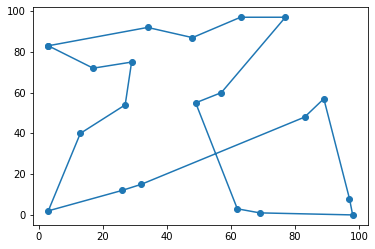

In [29]:
# A baseline or "benchmark" path
benchmark_path = [16, 0, 13, 19, 14, 15, 6, 2, 5, 11, 1, 10, 17, 7, 8, 4, 9, 3, 18, 12]
print('"Mediocre" baseline path: {}'.format(benchmark_path))
plot_path(benchmark_path, CITIES)
print('Length of this path: {}'.format(calculate_path_distance(benchmark_path, CITIES)))

**Exercise 3** (3 points): You will now implement the full algorithm below. As a refresher, here are the steps required:

1. Start with a random path of the cities. We have provided `RANDOM_PATH` as the start point. For this exercise, you will only need to implement the algorithm on the 20 cities.
2. Iterate over a sequence of "temperatures" -- we have provided a loop for you that starts the temperature at 100,000 and decreases it to the value of 1 in logarithmic fashion, using the [numpy.logspace](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.logspace.html) function. For each such temperature `k` you will:
    * Randomly swap two cities in the path
    * If the newly created path is shorter, accept it, and if not, accept it only with probability ***p***

And at the end, you will be left with an optimized path of cities.

The only step that you have not already implemented is thresholding the acceptance probability ***p***. Use Python's random number generators to emulate "flipping a (biased) coin" to decide whether to accept a longer path, given `k`.

Final path: [8, 4, 11, 5, 1, 10, 17, 7, 2, 6, 15, 14, 19, 13, 0, 16, 12, 18, 3, 9]
The length of this path: 443.24201844482667


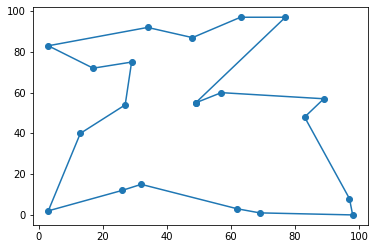

In [36]:
path = RANDOM_PATH
for k in np.logspace(0, 5, num=100000)[::-1]: # Iterate the "temperature" from k=100,000 down-to 1, logarithmically
    
    [i, j] = random.sample(range(20), 2)
    new_path = swap_cities(path, i, j)
    path_len = calculate_path_distance(path, CITIES)
    new_path_len = calculate_path_distance(new_path, CITIES)
    
    
    if random.random() < acceptance_probability(path_len, new_path_len, k):
        path = new_path


print("Final path: {}".format(path))
print("The length of this path: {}".format(calculate_path_distance(path, CITIES)))
plot_path(path, CITIES)

In [37]:
# Test cell: `final_algorithm`
assert calculate_path_distance(path, CITIES) < calculate_path_distance(benchmark_path, CITIES), 'Your shortest path can not beat the benchmark path.'
print("\n(Passed.)")


(Passed.)



**Fin!** That's the end of this problem. Don't forget to restart and run this notebook from the beginning to verify that it works top-to-bottom before submitting. You can move on to the next problem